<a href="https://colab.research.google.com/github/Jyo172/Predicting-Amount-Spent-during-stayat-Resort/blob/master/AmountPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files, drive
drive.mount('gdrive', force_remount=True)

Mounted at gdrive


In [0]:
!cp 'gdrive/My Drive/train_club.zip' .

In [6]:
!unzip train_club.zip

Archive:  train_club.zip
  inflating: Data_Dictionary.xlsx    
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from datetime import *

In [61]:
train = pd.read_csv('train.csv')
train.head()

,reservation_id,booking_date,checkin_date,checkout_date,channel_code,main_product_code,numberofadults,numberofchildren,persontravellingid,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,member_age_buckets,booking_type_code,memberid,cluster_code,reservationstatusid_code,resort_id,amount_spent_per_room_night_scaled
0,07659f3758d8aee27f5a7e2887adeacb67021cb95ada1b...,05/04/18,05/04/18,06/04/18,3,1,2,0,46,3,3,3,1,2.0,7.0,3,3,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,C,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...,7.706428
1,03930f033646d073462b35d411616323597715ac4fc398...,23/01/15,11/04/15,16/04/15,1,1,2,0,46,3,3,4,5,2.0,7.0,5,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,F,A,39fa9ec190eee7b6f4dff1100d6343e10918d044c75eac...,6.662563
2,d145a32920e6587ad95bfe299d80c0affa268220535aaf...,28/01/15,01/02/15,05/02/15,1,1,2,0,47,1,5,4,4,2.0,7.0,1,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,E,A,535fa30d7e25dd8a49f1536779734ec8286108d115da50...,7.871602
3,cfd77f44811ed62f25a220b53324cdbafc662a4c9e5f04...,02/05/15,11/06/15,16/06/15,1,1,2,2,46,2,2,3,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,5.344943
4,937cff9e4dcfc2459620153dfc8b9962ac22bea67dfb29...,02/09/15,14/12/15,19/12/15,1,1,2,0,46,2,2,4,5,2.0,7.0,2,2,F,1,3d1539e56495b6991f0a3ef5a61ca3d03ce4fff7380e9a...,D,A,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,7.059346


In [0]:
#Removing reservation_id,memberid,resort_id
train=train.drop(['reservation_id','memberid','resort_id'],axis=1)

In [0]:
#datetime manipulations
train['booking_date']=pd.to_datetime(train['booking_date'],dayfirst=True)
train['checkin_date']=pd.to_datetime(train['checkin_date'],dayfirst=True)
train['checkout_date']=pd.to_datetime(train['checkout_date'],dayfirst=True)

In [64]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341424 entries, 0 to 341423
Data columns (total 21 columns):
booking_date                          341424 non-null datetime64[ns]
checkin_date                          341424 non-null datetime64[ns]
checkout_date                         341424 non-null datetime64[ns]
channel_code                          341424 non-null int64
main_product_code                     341424 non-null int64
numberofadults                        341424 non-null int64
numberofchildren                      341424 non-null int64
persontravellingid                    341424 non-null int64
resort_region_code                    341424 non-null int64
resort_type_code                      341424 non-null int64
room_type_booked_code                 341424 non-null int64
roomnights                            341424 non-null int64
season_holidayed_code                 341310 non-null float64
state_code_residence                  336660 non-null float64
state_code_resort 

In [0]:
#handling missing values
train['season_holidayed_code'].fillna(train['season_holidayed_code'].mode()[0],inplace=True)
train['state_code_residence'].fillna(train['state_code_residence'].mode()[0],inplace=True)

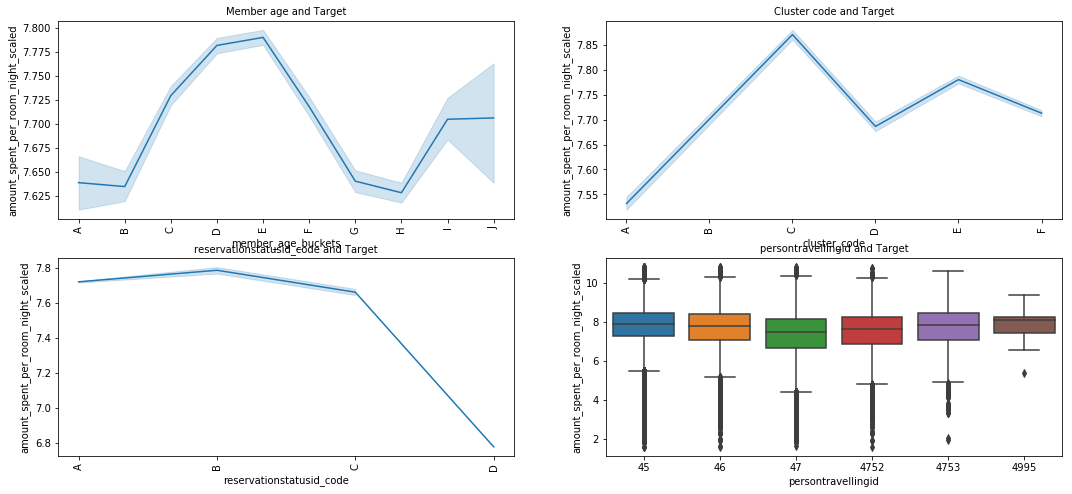

In [66]:
#handling categorical values
target='amount_spent_per_room_night_scaled'
plt.rcParams['figure.figsize'] = (18, 8)
plt.subplot(2, 2, 1)
sns.lineplot(train['member_age_buckets'],train[target])
plt.title('Member age and Target', fontsize = 10)
plt.xticks(rotation = 90)

plt.subplot(2, 2, 2)
sns.lineplot(train['cluster_code'], train[target])
plt.title('Cluster code and Target', fontsize = 10)
plt.xticks(rotation = 90)

plt.subplot(2, 2, 3)
sns.lineplot(train['reservationstatusid_code'], train[target])
plt.title('reservationstatusid_code and Target', fontsize = 10)
plt.xticks(rotation = 90)

plt.subplot(2, 2, 4)
sns.boxplot(train['persontravellingid'], train[target])
plt.title('persontravellingid and Target', fontsize = 10)

plt.show()

In [0]:
#label encoding member age buckets,cluster code and reservationstatusid and getting dummies for persontravellingid
train['member_age_buckets'].replace(('A', 'B', 'G', 'H'), (1, 1, 1, 1), inplace = True)
train['member_age_buckets'].replace(('I', 'J'), (2, 2), inplace = True)
train['member_age_buckets'].replace(('C', 'D', 'E', 'F'), (3, 3, 3, 3), inplace = True)
train['cluster_code'].replace(('A', 'B', 'C', 'D', 'E', 'F'),(1, 2, 6, 3, 5, 4), inplace = True)
train['reservationstatusid_code'].replace(('A', 'B', 'C', 'D'), (2.4, 2.5, 2.3, 1), inplace = True)

In [0]:
#dummy data for persontravellingid
train=pd.get_dummies(train, columns =['persontravellingid'])

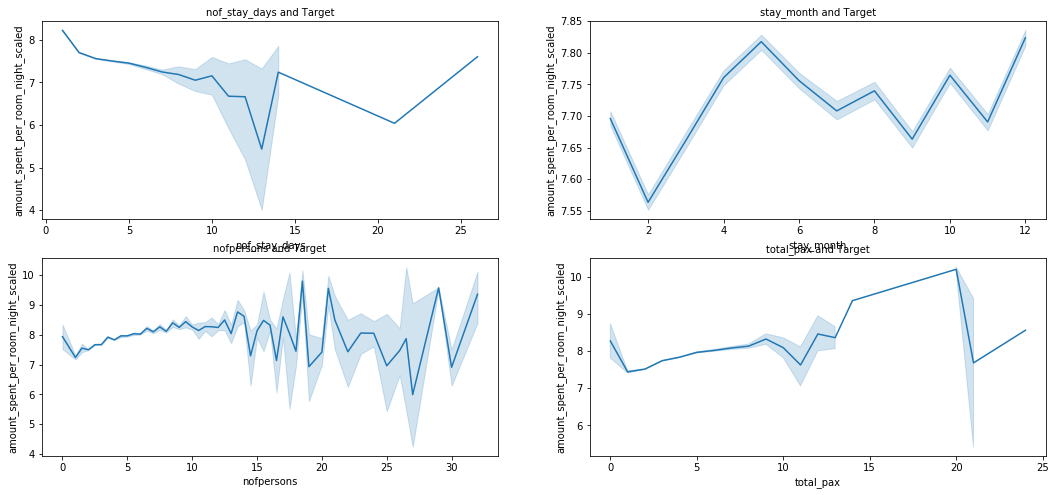

In [69]:
#Feature engineering
train['nof_stay_days']=(train['checkout_date']-train['checkin_date']).dt.days
train['stay_month']=train['checkin_date'].dt.month
train['nofpersons']=train['numberofadults']+0.5*train['numberofchildren']

plt.rcParams['figure.figsize'] = (18, 8)
plt.subplot(2, 2, 1)
sns.lineplot(train['nof_stay_days'], train[target])
plt.title('nof_stay_days and Target', fontsize = 10)

plt.subplot(2, 2, 2)
sns.lineplot(train['stay_month'], train[target])
plt.title('stay_month and Target', fontsize = 10)

plt.subplot(2, 2, 3)
sns.lineplot(train['nofpersons'], train[target])
plt.title('nofpersons and Target', fontsize = 10)

plt.subplot(2, 2, 4)
sns.lineplot(train['total_pax'], train[target])
plt.title('total_pax and Target', fontsize = 10)

plt.show()

In [0]:
#taking log for nof_stay_days and encoding stay_month
train['stay_month'].replace((1,2,3,4,5,6,7,8,9,10,11,12),(3,1,3,5,6,5,3,4,2,5,3,6),inplace=True)


In [0]:
train=train.drop(['checkin_date','checkout_date','booking_date'],axis=1)

In [0]:
X=train.drop(target,axis=1)
y=train[target]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

In [73]:
import xgboost as xgb
xgb = xgb.XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_gb = xgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse)
print("RMSE :", rmse_gb)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE : 0.9976529496205637
